## DCA Workshop
#### This is a Jupyter notebook guide to running a Direct Coupling Analysis with mfDCA.
#### While this script can be run start to finish with no effort on your part by hitting the "Run All" button, the goal is ultimately for you to understand at every step what is happening.
#### I encourage you to open the files and try to understand what is contained in them.
#### BEFORE running, make sure to follow the README in the github to set up an environment to run this.

#### This guide will cover:
#### - Downloading an MSA from Pfam
#### - Filtering the MSA to improve DCA results
#### - Downloading a PDB and pulling the fasta file and native contacts from it.
#### - Aligning the PDB fasta to the Pfam MSA.
#### - Ranking, filtering, and plotting DI pairs.


In [19]:
import os 
import subprocess
from requests import get
from dca import dca_class, dca_analysis, helper_functions
from Bio import SeqIO 
import numpy as np 
import matplotlib.pyplot as plt 

#### Step 1: Downloading from Pfam.
##### Pfam is a curated database for multiple sequence alignments of protein domains.
##### The MSAs are of high quality and typically give good results in our analysis.
##### Make sure to look at this page: https://pfam.xfam.org/family/PF01401 , and read their FAQ for more info on what the database is and how the MSA are created.
##### There are a number of tabs that you can look at with different useful information on the proteins that exist in this "family".
##### We will be downloading the "Full" MSA under the alignments tab; there are other MSA you can try on your own.


In [20]:
# checks for a data folder; outputs all files to data folder
if not os.path.isdir('data'): 
    os.makedirs('data')

def data_dir(filename: str) -> str:
    '''platform agnostic directory handling. 
    wrap a filename, returns data/filename'''
    return os.path.join('data',filename)

In [21]:
# This analysis will be guided for a specific protein and Pfam family, listed here as variables.
path_to_hmmer = '/Users/jonathanmartin/Code/built_apps/hmmer' # use Windows backslashes if you need to.
pfam_ID = 'PF01401'
pdb_ID = '1R42'

In [23]:
# downloads and saves the PFAM MSA into the data folder
url_download = get('http://pfam.xfam.org/family/'+pfam_ID+'/alignment/full/format?format=fasta&alnType=full&order=t&case=l&gaps=default&download=1')
with open( data_dir('pfam_full_'+pfam_ID+'.fasta') ,'wb') as file:
    file.write(url_download.content)

#### Step 2: Filtering the Pfam MSA.
##### The Pfam MSA has many characters we do not use (lowercase letters and periods).
##### After removing these characters, some sequences will have a large amounts of consecutive gaps.
##### Consecutive gaps often add noise and detract from the quality of the analysis, so we do some filtering to remove sequences which have too many consecutive gaps.
##### This notebook filters at 20% of the length of the aligned sequence, so a sequence of length 100 with 21 consecutive '-' characters is removed from the MSA.
##### This file will be saved with "filtered_" appended, and will be used for the rest of the analysis.

In [24]:
# clean sequences
helper_functions.clean_pfam( data_dir('pfam_full_'+pfam_ID+'.fasta'), 
                            data_dir('clean_pfam_full_'+pfam_ID+'.fasta'))

# get final sequence length and calculate max number of consecutive gaps to allow
msa_gap_percentage = 20
pfam_sequence_length = len(next(SeqIO.parse( data_dir('clean_pfam_full_'+pfam_ID+'.fasta') ,'fasta')))
max_gaps = round( msa_gap_percentage * pfam_sequence_length / 100 )

#save filtered_ MSA for use later in the notebook.
helper_functions.filter_pfam( data_dir('clean_pfam_full_'+pfam_ID+'.fasta'), max_gaps, 
                            data_dir('filtered_'+str(msa_gap_percentage)+'pct_pfam_full_'+pfam_ID+'.fasta'))

Original number of sequences: 3687

Number(%) of sequences excluded: 1021 (27.69%)



#### Step 3: Downloading the PDB.
##### We are downloading our PDBs from https://www.rcsb.org, the Protein Data Bank.
##### The PDB ID above will be used to download the PDB, and then we will extract its amino acid sequence and its native contacts.
##### The native contacts are calculated from the PDB, and it is saved as a list of pairs of residues in the protein structure which are within some distance of each other. Here we will be using <=10 angstroms between the C-alpha carbon of the residues as the cutoff distance, saved as 'native_contacts_calpha'. This file will be used later, and should have pairs of numbers inside.
##### You can also choose a cutoff that uses all atoms in the PDB. This means that if any atom in a residue is within some cutoff distance of an atom in another residue, then that pair of residues will be output to a file ('native_contacts_allatoms')

In [25]:
# Downloading PDB file...
pdb_file = get('https://files.rcsb.org/download/'+pdb_ID+'.pdb')
with open( data_dir(pdb_ID+'.pdb') ,'wb') as fd:
    fd.write(pdb_file.content)
# Downloading PDB fasta file...
pdb_fasta_file = get('https://www.rcsb.org/fasta/entry/'+pdb_ID)
with open( data_dir(pdb_ID+'.fasta') ,'wb') as fd:
    fd.write(pdb_fasta_file.content)

In [26]:
# calculate distances, calpha or allatoms
# change "interface_contacts_calpha" to "interface_contacts_allatoms" for allatoms. 
angstrom_cutoff = 10
output_contact_filename = helper_functions.interface_contacts_calpha( data_dir(pdb_ID+'.pdb'), 'A', 'A', angstrom_cutoff )

# Create Native Pairs file. 
# If you changd calpha to allatoms, you'll have to change 5 values in this code. Check the contactmap_allatoms file for help
output_native_filename = data_dir('native_contacts_' + output_contact_filename.split('_')[1])
with open(output_native_filename,'w') as output:
    with open(output_contact_filename,'r') as fd:
        for  line in fd:
            split_line = line.split()
            if split_line[0] == 'res': # skip first line of file
                continue 
            elif int(split_line[0]) > 0 and int(split_line[3]) > 0: 
                pairs = ' '.join([split_line[0],split_line[3]])
                output.writelines(pairs+'\n')


	Number of interactions found: 5384


	File saved as: contactmap_calpha_data/1R42_AA_10



#### Step 4: Aligning the PDB sequence to the MSA.
##### The MSA generated by Pfam will likely not look like the sequence of your real protein; it will often be shorter, or even a small subset of the protein you are looking at. It will also have deletions and insertions relative to your protein sequence. This is because the MSA was generated by trying to find generally consistent features of the "family" of protein domains and might not include your particular protein's residues.
##### This means that aligning your PDB of interest is not straightforward. Luckily the HMMER package makes this simple for you.
##### The HMM file for your particular Pfam ID is in the "Model and Curation" tab on Pfam. This can be used to align any sequence to your MSA, because the MSA was made with the HMM file.
##### This section downloads the HMM file, then uses the HMMER package to align your pdb sequence. It returns a dictionary, mapping MSA coordinates to PDB coordinates. MSA position 1 -> PDB position 12, for example.
##### A formatted alignment file will also be saved as "pdb_id.align". This is an important file to check if the results are poor; it's a common place where the DI pairs from DCA get offset from the PDB itself and cause poor contact prediction.

In [27]:
# download hmm profile
hmm_file = get('http://pfam.xfam.org/family/'+pfam_ID+'/hmm')
with open( data_dir(pdb_ID+'.hmm'),'wb') as fd: 
    fd.write(hmm_file.content)

# Use hmmpress to prepare hmmprofile for use
subprocess.run([path_to_hmmer+'/bin/hmmpress', data_dir(pdb_ID+'.hmm')])

# Scan your sequence to the alignment
subprocess_command = [path_to_hmmer+'/bin/hmmscan', '-o', data_dir(pdb_ID+'.scan'),
                         '--notextw', data_dir(pdb_ID+'.hmm'), data_dir(pdb_ID+'.fasta') ]
subprocess.run(subprocess_command)

Working...    done.
Pressed and indexed 1 HMMs (1 names and 1 accessions).
Models pressed into binary file:   data/1R42.hmm.h3m
SSI index for binary model file:   data/1R42.hmm.h3i
Profiles (MSV part) pressed into:  data/1R42.hmm.h3f
Profiles (remainder) pressed into: data/1R42.hmm.h3p


CompletedProcess(args=['/Users/jonathanmartin/Code/built_apps/hmmer/bin/hmmscan', '-o', 'data/1R42.scan', '--notextw', 'data/1R42.hmm', 'data/1R42.fasta'], returncode=0)

In [28]:
# parse the scan file to build an align file, to be used later. 
important_scan_lines = []
start_recording = False
counter = 0
with open( data_dir(pdb_ID+'.scan'),'r') as fd:
    for line in fd:
        if 'domain' in line and 'score' in line and 'E-value' in line: # start recording lines
            start_recording = True 
            continue # jump to next iteration in for loop
        else:
            if start_recording:
                important_scan_lines.append(line.rstrip())
                counter+=1
            if counter == 4:
                break 

# build align file
with open( data_dir(pdb_ID+'.align'), 'w') as output:
    for alignment in [ important_scan_lines[1], important_scan_lines[3] ]:
        to_print = alignment.split()
        for line in to_print:
            output.writelines(line+'\n')
        output.writelines('\n')

# build alignment dictionary
alignment_dictionary = helper_functions.backmap_alignment( data_dir(pdb_ID+'.align') )

#### Step 5: Run analysis, plot results!
##### Almost there! Now we can run DCA using the cleaned and filtered fasta file we've created. Then, we can use one of the outputs of DCA, the DI scores, to rank pairs of positions in the MSA by how strongly they are interacting.
##### The DI score is a measure of the strength of couplings between any two positions in the MSA. So if residue 1 and residue 20 are covarying (changing together) across all/most sequences in your dataset, then this might get a large DI score. If positions 2 and 19 do not seem to change with each other as you look at each individual sequence in the dataset, then this would get a lower DI score. 
##### Once we have these DI pairs, we can then align them to the PDB coordinates so that we can predict which positions in the PDB structure are interacting based *solely* on the statistics of natural sequences from databases.
##### We then visualize the interaction using the contact map, where the pairs of positions are represented as (pos1, pos2) on an (x,y) grid.
##### We do some further processing:
##### - The DI pairs which are <4 positions away are often highly correlated/coupled (1 and 2, 1 and 3, etc). We're not interested in these positions, so we can filter them out to see distant pairs which are strongly coupled.
##### - We plot only a subset of the DI pairs after they're ranked and filtered. The DI metric gives a score for every possible pair of positions, and many of them will have very low scores. We plot the highest few because they have the best chance of being real interactions expected in any member of the protein/domain family. You can change these parameters in the script, but we will plot the top N=(length of alignment) pairs.

In [31]:
# Run DCA with the cleaned/filtered MSA.
dca_model = dca_class.dca( data_dir('filtered_'+str(msa_gap_percentage)+'pct_pfam_full_'+pfam_ID+'.fasta') )
dca_model.mean_field() # runs the analysis. Might take a while!

# Rank the pairs.
ranked_di_pairs = dca_model.DI[ np.argsort( dca_model.DI[:,2] )[::-1] ]

# Filter out pairs that are too close, and map pairs 
# with alignment dictionary from previous step
mapped_di_pairs = dca_analysis.map_filter_DIpairs(alignment_dictionary, ranked_di_pairs)

# Take top N pairs
top_N_pairs = mapped_di_pairs[:pfam_sequence_length,:2]

# Load the native pairs.
native_pairs = np.loadtxt(output_native_filename)

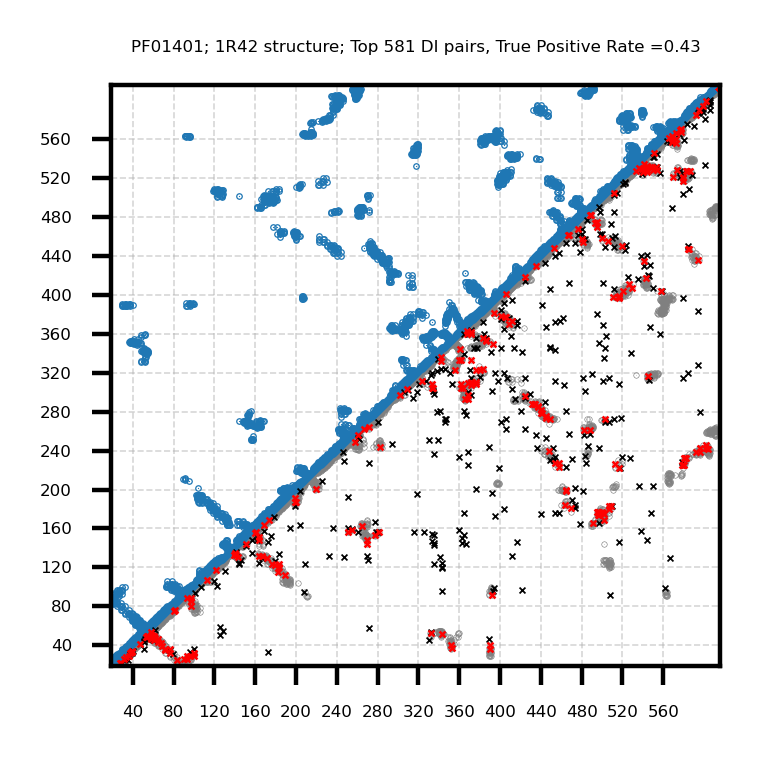

In [32]:
# Create the plot!
plot_figure, true_positive_rate, di_pair_hits = dca_analysis.plot_top_pairs(native_pairs, top_N_pairs, figure_size=(2,2))
plt.title(pfam_ID+'; '+pdb_ID+' structure; Top '+str(pfam_sequence_length)+' DI pairs, True Positive Rate ='+ str(round(true_positive_rate,2)),fontsize=3 );
plot_figure.tight_layout();

##### Finally, you can double check that all of this worked by looking at what pairs of residues mfDCA predicted in the PDB structure. 
##### You can visualize the downloaded PDB with PyMOL or ChimeraX, then check the red dots from the plot above to see if these pairs are correct. It's good to perform this check and others as its easy to be misled by bugs in code. Don't trust that this script works, investigate the code yourself!

In [ ]:
# These are the DI pair hits. Pairs that ==1 are red, pairs that ==0 are gray in the plot above.
print( di_pair_hits[ di_pair_hits[:,2] == 1 ] )